In [22]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Estimating the Covariance Matrix

In this tutorial, we estimate the covariance matrix power spectrum between two maps of the CMB which have the same pixelization and signal, but different noise realizations. This scenario resembles power spectrum analysis performed using two data splits. The key ingredients are the auto- and cross-power spectra, which are used together to estimate the signal and noise power spectra of the maps.

First, we import the necessary libraries.

In [23]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import nawrapper as nw
import nawrapper.maptools as maptools

For realism, we apply a mild Gaussian beam of 0.2 degrees to both maps.

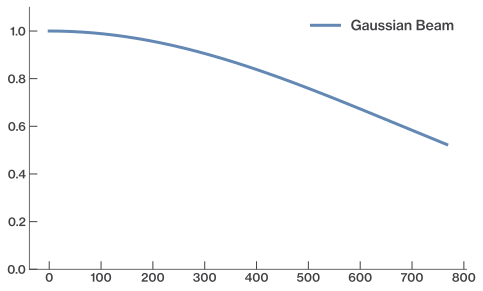

In [24]:
nside = 256
lmax = nside * 3 - 1
B_ell = hp.sphtfunc.gauss_beam(np.deg2rad(0.2), lmax=lmax)

plt.plot(B_ell, '-', label='Gaussian Beam')
plt.ylim(0.0, 1.1)
plt.legend()

We also apply the pixel window when generating these maps. 


## Some Example Input Spectra

For this example, we'll create some simulated CMB data, with theory temperature and polarization spectra from the Boltzmann code CLASS. These have already been generated in a text file, `data/example_cls.txt` in the repository.

In [25]:
ell, cltt, clte, clee, clbb = np.genfromtxt(
    'data/example_cls.txt', unpack=True)

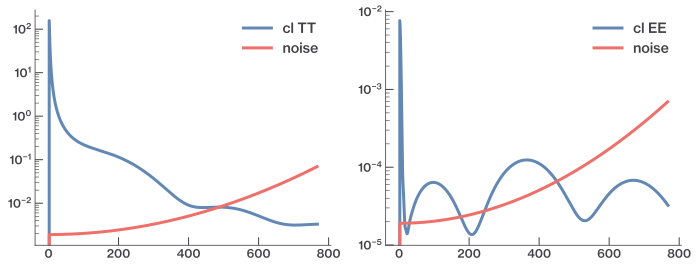

In [26]:
nltt = nw.get_Nl(theta_fwhm=20.0, sigma_T=150, l_max=lmax+1)
nlee = nltt / 100
# nl[0:2] = 0.0

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].plot(cltt, '-', label='cl TT')
axes[0].plot(nltt, '-', label='noise')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot(clee, '-', label='cl EE')
axes[1].plot(nlee, '-', label='noise')
axes[1].set_yscale('log')
axes[1].legend()

We'll generate a realistic looking Galactic mask by putting in a silly combination of sines towards the equator.

/fs/lustre/cita/zack/condaenvs/ps/lib/python3.9/site-packages/healpy/visufunc.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pylab.draw()
/fs/lustre/cita/zack/condaenvs/ps/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


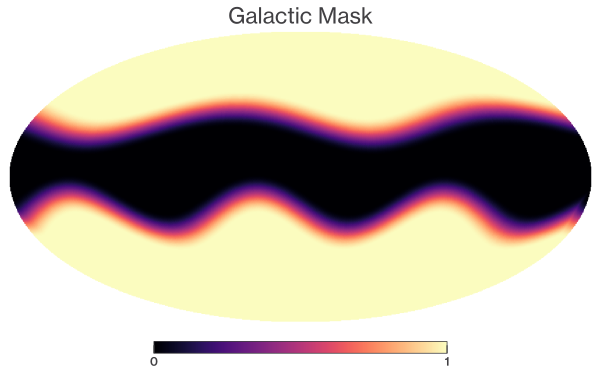

In [27]:
msk = np.zeros(hp.nside2npix(nside))
th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
ph[np.where(ph > np.pi)[0]] -= 2 * np.pi
msk[np.where((th * (1 + 0.1 * np.sin(ph*3.1+0.1)) > 1.7) | 
             (th * (1 + 0.1 * np.sin(ph*2)) < 1.25) )[0]] = 1.
mask = nmt.mask_apodization(msk, 20.0, apotype='C2')
hp.mollview(mask, title='Galactic Mask')

For this example, I'll use a binning size width of 10 multipoles.

**Here I set the first map to be 1.5x the map of the second, to make the signal spectra different.**

In [28]:
bins=nw.nabin(lmax=3*nside-1, nlb=10)

In [29]:
def get_maps():
    # apply the pixel window transfer function (pixwin=True)
    #TT, EE, BB, TE, EB, TB
    #I've set EB and TB = 0
    m = hp.synfast(
        (cltt, clee, clbb, 
         clte, np.zeros_like(cltt), np.zeros_like(cltt)), 
        nside, verbose=False, pixwin=True, new=True)
    
    # BB noise is set to same as EE noise
    n1 = hp.synfast(
        (nltt, nlee, nlee, 
         np.zeros_like(cltt), np.zeros_like(cltt), np.zeros_like(cltt)), 
        nside, verbose=False, pixwin=True, new=True)
    n2 = hp.synfast(
        (nltt, nlee, nlee, 
         np.zeros_like(cltt), np.zeros_like(cltt), np.zeros_like(cltt)), 
        nside, verbose=False, pixwin=True, new=True)
    
    # smooth the maps with the beam we made up earlier
    m1_data = hp.smoothing(m * 1.5 + n1, beam_window=B_ell, verbose=False)  # SET UP 
    m2_data = hp.smoothing(m + n2, beam_window=B_ell, verbose=False)
    
    # Make the namap!
    m1 = nw.namap_hp(maps=(m1_data), masks=mask,
                  beams=B_ell, verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m2_data), masks=mask,
                  beams=B_ell, verbose=False, unpixwin=True)
    return m1, m2

## Simplest Possible Case: Turn `namap` Into Spectra and Covmat
In this super simple example, we compute the TT spectrum and associated errors.

**If the signals are different, you must set `different_signals=True`**.

In [30]:
# create some namap objects
map1, map2 = get_maps()

spectra = nw.compute_spectra(map1, map2, bins)
covmat = nw.compute_covmat(map1, map2, bins, different_signals=True)  # NOTE: different_signals set to True

KeyboardInterrupt: 

That's it, you're done! The resulting `covmat` is a dictionary with keys like `TTTE`, for example, which has covariance of $C_{\ell}^{TT}$ with respect to $C_{\ell}^{TE}$. Let's plot stuff.

Text(0, 0.5, '$\\ell^2 C_{\\ell}$')

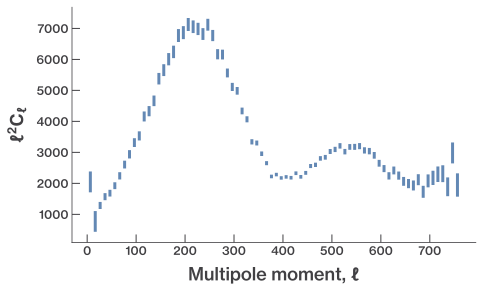

In [ ]:
# need TT error for this plot, it's the sqrt of the variance
# variance is the diagonal of the covariance
cltt_error = np.sqrt(np.diag(covmat['TTTT']))

plt.errorbar(spectra['ell'], 
             spectra['TT'] * spectra['ell']**2, 
             yerr=cltt_error * spectra['ell']**2, 
             ls='none')

plt.xlabel(r'Multipole moment, $\ell$')
plt.ylabel(r'$\ell^2 C_{\ell}$')

# Validation
Let's check that the results of this, by doing some Gaussian simulations of this map and seeing if it worked. This will take a minute or two to simulate everything.

In [ ]:
# we will reuse the mode coupling object since the mask remains the same
map1, map2 = get_maps()
mc_12 = nw.mode_coupling(map1, map2, bins)

# generate fake signal realization, with two noise realizations
# like a data split!
def get_spec():
    m1, m2 = get_maps()
    return nw.compute_spectra(m1, m2, mc=mc_12, verbose=False)

Computing new mode-coupling matrices.


In [ ]:
from tqdm import tqdm
import pickle

samples = [get_spec() for i in tqdm(range(100))]

100%|██████████| 100/100 [11:46<00:00,  7.07s/it]


## Spectra Check
It's nice to check that the spectra themselves have the same mean. I wouldn't trust any multipole with $\ell > 2 N_{\text{side}}$.

Text(0, 0.5, '$\\ell^2 C_{\\ell}$')

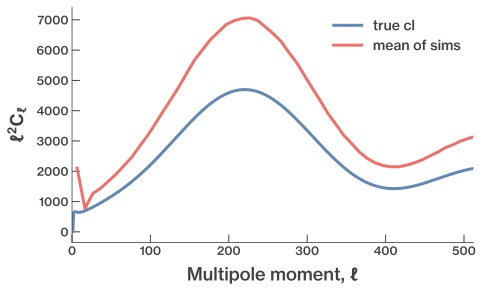

In [ ]:
plt.plot(cltt * np.arange(len(cltt))**2, label='true cl')

ells = bins.get_effective_ells()
plt.plot(ells, 
         np.mean([s['TT'] for s in samples], axis=0) * ells**2, 
         label='mean of sims')

plt.legend()

plt.xlim(0, 2*nside)
plt.xlabel(r'Multipole moment, $\ell$')
plt.ylabel(r'$\ell^2 C_{\ell}$')

### Check Sample Error vs. Our Analytic Estimate

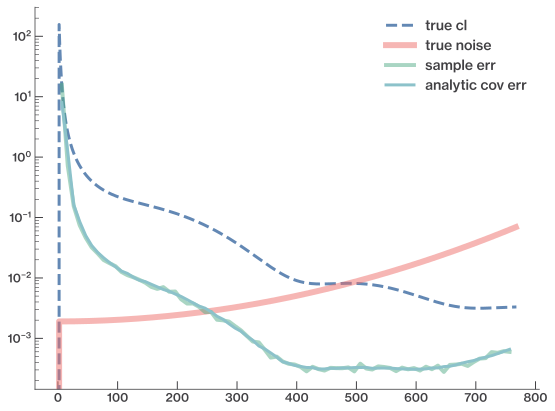

In [ ]:
plt.figure(figsize=(8,6))

ells = bins.get_effective_ells()
plt.plot(cltt, '--', label='true cl')
plt.plot(nltt, '-', label='true noise', alpha=0.5, lw=6)

plt.plot(ells, np.std([s['TT'] for s in samples], axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot(ells, cltt_error, "-", label='analytic cov err')

plt.legend()
plt.yscale('log')

In [ ]:
m1, m2 = get_maps()
cov = nw.nacov(m1, m2, mc_11=mc_12, mc_12=mc_12, mc_21=mc_12, mc_22=mc_12, 
    different_signals=True)  # NOTE: different_signals is set to true here
cov.compute()

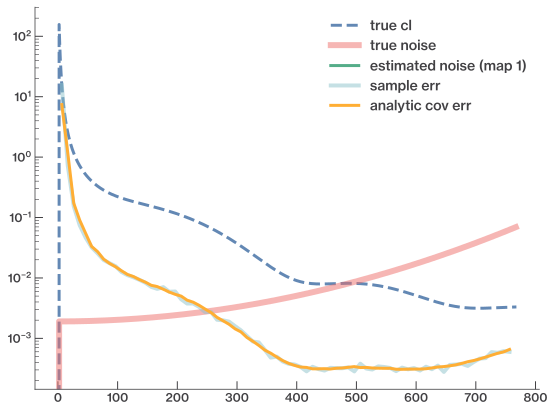

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(cltt, '--', label='true cl')
plt.plot(nltt, '-', label='true noise', alpha=0.5, lw=6)
plt.plot(cov.noise['T1T1'], '-', label='estimated noise (map 1)')
plt.plot(ells, np.std([s['TT'] for s in samples], axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot(ells, np.sqrt(np.diag(cov.covmat['TTTT'])), "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

(0.0, 1.2)

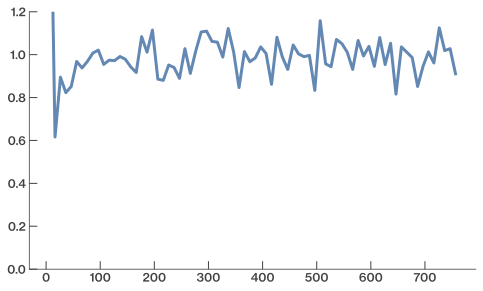

In [ ]:
plt.plot(cov.lb, np.std([s['TT'] for s in samples], axis=0) / 
         np.sqrt(np.diag(cov.covmat['TTTT'])) )
plt.ylim(0.0,1.2)

### Check Polarization Too

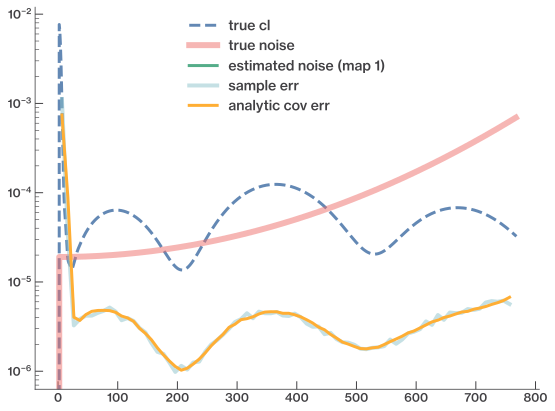

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(clee, '--', label='true cl')

plt.plot(nlee, '-', label='true noise', alpha=0.5, lw=6)
plt.plot(cov.noise['E1E1'], '-', label='estimated noise (map 1)')
plt.plot(ells, np.std([s['EE'] for s in samples], axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot(ells, np.sqrt(np.diag(cov.covmat['EEEE'])), "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

(0.0, 1.2)

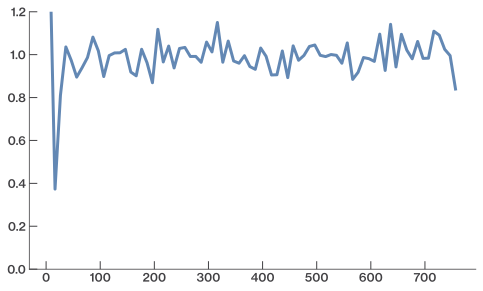

In [ ]:
plt.plot(cov.lb, np.std([s['EE'] for s in samples], axis=0) / 
         np.sqrt(np.diag(cov.covmat['EEEE'])) )
plt.ylim(0.0,1.2)

## More Complicated Stuff

We'll now describe more details about how to turn `namap` objects into covariance matrices.

### Some Review
Recall that computing a **spectrum** requires
* `namap1` (`namap`)
* `namap2` (`namap`)
* `bins` (`nmt_bin`)
* `mc` (`mode_coupling`). *OPTIONAL*

In this case, `mc` is the mode coupling matrix describing the effects of the mask for a cross-spectrum between `namap1` and `namap2`. This will be computed for you if you don't pass it, but it's the slowest part of the power spectrum estimation process. If you're processing a bunch of maps with the same mask/beam, then they will share the same mode-coupling matrix. This might happen if you're computing a set of simulations, for example! In this case, it's much faster to compute the mode-coupling matrix once, and pass it to `compute_spectra` for all your different `namap` combinations that share those masks and beams.

### Covmat: Similar Stuff
Computing a **covariance matrix** requires basically the same inputs.

* `namap1` (`namap`)
* `namap2` (`namap`)
* `bins` (`nmt_bin`)
* `mc_11` (`mode_coupling`). *OPTIONAL*
* `mc_12` (`mode_coupling`). *OPTIONAL*
* `mc_22` (`mode_coupling`). *OPTIONAL*

You'll notice that there are now three mode coupling objects here. These will all be computed for you if you don't pass them, and each one corresponds to the mode coupling within different pairs of maps. That is, `mc_12` refers to the mode coupling in the cross spectrum between `namap1` and `namap2` (the same as `mc` in the `compute_spectra` call). However, `mc_11` corresponds to the mode coupling in the *auto-spectrum* of `namap1` with itself. This auto-spectrum will have the noise of `namap1` in it, which is why we want to compute it in the covariance matrix calculation.

In [ ]:
# get your two example namaps
map1, map2 = get_maps()

# compute the mode coupling object for the cross-spectrum
mc_12 = nw.mode_coupling(map1, map2, bins=bins)

# compute the spectra using that mode coupling object
Cb_12 = nw.compute_spectra(map1, map2, mc=mc_12) 


# compute the mode coupling objects of the auto-spectra
mc_11 = nw.mode_coupling(map1, map1, bins=bins)
mc_22 = nw.mode_coupling(map2, map2, bins=bins)

# compute the covariance matrix also with that mode coupling object
covmat = nw.compute_covmat(map1, map2, 
                           mc_11=mc_11, mc_12=mc_12, mc_22=mc_22)

Computing new mode-coupling matrices.
Computing new mode-coupling matrices.
Computing new mode-coupling matrices.


KeyboardInterrupt: 

## Important: Specifying the Noise and Signal
To get the best estimate of the covariance matrix, you need to pass `compute_covmat` a `signal` and `noise` dictionary. Both `signal` and `noise` are dictionaries containing unbinned spectra up to `lmax`. The signal spectra need to pass keys like `TT`, `TE`, etc. The noise spectra must have keys of the form `T1T1`, `E2E2`, etc, corresponding to noise power spectra between i.e. the temperature map 1 and temperature map 1, for `T1T1`. 

In [ ]:
m1, m2 = get_maps()
cov = nw.nacov(m1, m2, mc_11=mc_12, mc_12=mc_12, mc_22=mc_12, 
               signal={'TT':cltt, 'EE':clee, 'TE':clte, 'ET':clte},
               noise={'T1T1':nltt, 'T2T2':nltt, 'E1E1':nlee, 'E2E2':nlee}
              )
cov.compute()

: 

## Off-Diagonal Blocks

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sampstack = np.hstack( [[s['TT'] for s in samples], [s['TE'] for s in samples]] ).T
subcov = np.cov(sampstack)[:-len(ells), -len(ells):]
ax[0].plot(ells, np.diag(subcov) * ells**4, '-', lw=4, alpha=0.3, label=r'sample err $(n=300)$')
ax[0].plot(ells, np.diag(cov.covmat['TTTE']) * ells**4, "-", label='analytic cov err')
ax[0].legend()
ax[0].set_ylabel(r'$\mathbf{C}_{\ell \ell}^{TTTE} \ell^4$')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylim(-300, 700)

sampstack = np.hstack( [[s['TT'] for s in samples], [s['EE'] for s in samples]] ).T
subcov = np.cov(sampstack)[:-len(ells), -len(ells):]
ax[1].plot(ells, np.diag(subcov) * ells**4, '-', lw=4, alpha=0.3, label=r'sample err $(n=300)$')
ax[1].plot(ells, np.diag(cov.covmat['TTEE']) * ells**4, "-", label='analytic cov err')
ax[1].legend()
ax[1].set_ylabel(r'$\mathbf{C}_{\ell \ell}^{TTEE} \ell^4$')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylim(-10, 20)
plt.tight_layout()
# plt.yscale('log')

: 

# Different Noise Levels in Each Map

In [ ]:
def get_maps_different():
    # apply the pixel window transfer function (pixwin=True)
    m = hp.synfast(B_ell[:lmax]**2 * cl, nside, verbose=False, pixwin=True)
    n1 = hp.synfast(B_ell[:lmax]**2 * nl, nside, verbose=False, pixwin=True)
    n2 = hp.synfast(B_ell[:lmax]**2 * (nl**1.2),nside, verbose=False, pixwin=True)
    m1 = nw.namap_hp(maps=(m + n1, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m + n2, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    return m1, m2

def get_spec_different():
    m1, m2 = get_maps_different()
    return nw.compute_spectra(m1, m2, lmax=lmax, verbose=False)['TT']

: 

In [ ]:
m1, m2 = get_maps_different()

: 

In [ ]:
from tqdm import tqdm
samples = [get_spec_different() for i in tqdm(range(50))]

: 

In [ ]:
m1, m2 = get_maps_different()

mc = nw.mode_coupling(m1, m2, bins=nw.get_unbinned_bins(lmax-1, nside=nside))
cov = nw.nacov(m1, m2, mc_11=mc, mc_12=mc, mc_22=mc)
cov.compute()

: 

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(cl, '--', label='true cl')
plt.plot(nl, '-', label='true noise (map 1)', alpha=0.5, lw=6)
plt.plot(nl**1.2, '-', label='true noise (map 2)', alpha=0.5, lw=6)
plt.plot(cov.noise['T1T1'], '-', label='estimated noise (map 1)')
plt.plot(cov.noise['T2T2'], '-', label='estimated noise (map 2)')
plt.legend()
plt.yscale('log')

plt.figure()
plt.plot(ells, np.std(samples, axis=0)[:2*nside], '-', lw=4, alpha=0.2, label='sample err')
plt.plot(ells, np.sqrt(np.diag(cov.covmat['TTTT']))[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

: 

: 

: 